<center><h1>Projet : Partie 5</h1></center>

<center><h1>Algorithmes de Clustering</h1></center>

## Importation des librairies et du dataset 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
from collections import Counter
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("data.xlsx")
df.drop(columns = df.columns[0], axis = 1, inplace= True)
df.drop(columns = df.columns[1], axis = 1, inplace= True)
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.56,2,0.72,Sales,0.00,0.25,Life Sciences,0.33,0,0.93,...,0.00,0.00,0.0,0.40,0.00,0.00,0.16,0.24,0.00,0.38
1,0.76,1,0.13,Research & Development,0.26,0.00,Life Sciences,0.67,1,0.45,...,0.86,1.00,0.5,0.50,0.50,0.67,0.27,0.41,0.07,0.54
2,0.46,2,0.91,Research & Development,0.04,0.25,Other,1.00,1,0.90,...,0.29,0.33,0.0,0.35,0.50,0.67,0.00,0.00,0.00,0.00
3,0.37,1,0.92,Research & Development,0.07,0.75,Life Sciences,1.00,0,0.38,...,0.00,0.67,0.0,0.40,0.50,0.67,0.22,0.41,0.21,0.00
4,0.34,1,0.65,Research & Development,0.04,0.25,Life Sciences,1.00,1,0.71,...,0.14,0.67,0.0,0.40,0.33,0.33,0.19,0.41,0.21,0.46


In [3]:
data = df.select_dtypes(include='number') #on ne garde que les variables numériques
data.head()

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.56,2,0.72,0.00,0.25,0.33,0,0.93,0.67,0.25,...,0.00,0.00,0.0,0.40,0.00,0.00,0.16,0.24,0.00,0.38
1,0.76,1,0.13,0.26,0.00,0.67,1,0.45,0.33,0.25,...,0.86,1.00,0.5,0.50,0.50,0.67,0.27,0.41,0.07,0.54
2,0.46,2,0.91,0.04,0.25,1.00,1,0.90,0.33,0.00,...,0.29,0.33,0.0,0.35,0.50,0.67,0.00,0.00,0.00,0.00
3,0.37,1,0.92,0.07,0.75,1.00,0,0.38,0.67,0.00,...,0.00,0.67,0.0,0.40,0.50,0.67,0.22,0.41,0.21,0.00
4,0.34,1,0.65,0.04,0.25,1.00,1,0.71,0.67,0.00,...,0.14,0.67,0.0,0.40,0.33,0.33,0.19,0.41,0.21,0.46


## Application d'algorithmes de clustering basé densité :

In [4]:
# Calculer la distance de manhattan entre tout les points du dataset
# Pour économiser du temps d'execution, on ne calcule que la matrice superieure de la matrice de distance
def manhattan_distance(df):
    distances = np.zeros((len(df), len(df)))
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            dist = np.sum(np.abs(df[i] - df[j]))
            
            distances[i][j] = dist
            distances[j][i] = dist

    return distances

# Retourner tous les points du dataset qui sont à une distance inférieure à eps de notre instance
def region_query(distances, i, eps):
    doc_indexes = np.where(distances[i] <= eps)[0] # On récupère les index des points qui sont à une distance inférieure à eps
    return [i for i in doc_indexes] # On retourne la liste des index des points

# Fonction qui permet de récursivement ajouter les points voisins à notre cluster
def expand_cluster(distances, document_cluster, clusters, C, neighbors, eps, min_pts):
    while len(neighbors)!=0: # Tant qu'il y a des voisins
        index_doc = neighbors.pop() # On récupère le premier voisin
        if document_cluster[index_doc] >=0 : continue # Si le point appartient déjà à un cluster et n'est pas du bruit, on passe au suivant
        document_cluster[index_doc] = C # On change la valeur -1 par le numéro du cluster pour indiquer que le point appartient à ce cluster
        clusters[C].append(index_doc) # On ajoute le point au cluster
        new_neighbors = region_query(distances,index_doc,eps) # On récupère les points voisins du point
        if len(new_neighbors)>= min_pts: neighbors.extend(new_neighbors) # Si le point a assez de voisins, on ajoute les voisins au cluster

# Fonction recréant l'algorithme DBSCAN
def dbscan(distances, eps, min_pts):
    # On itilisalise une liste a -1 pour chaque point du dataset (on ne connait pas encore son cluster)
    document_cluster = np.full(len(distances), (-1), dtype = np.int)
    clusters = [[]]
    noise = []
    C = 0
    for index_doc in range(len(distances)):
        if document_cluster[index_doc] != -1 : continue # Si le point appartient déjà à un cluster, on passe au suivant
        
        neighbors = region_query(distances,index_doc,eps) # On récupère les points voisins
        
        if len(neighbors) >= min_pts: # Si le point a assez de voisins, on crée un nouveau cluster
            document_cluster[index_doc] = C # On change la valeur -1 par le numéro du cluster pour indiquer que le point appartient à ce cluster
            clusters[C].append(index_doc) # On ajoute le point au cluster
            expand_cluster(distances, document_cluster, clusters, C, neighbors, eps, min_pts) # On ajoute les voisins du point au cluster
            C += 1 # On passe au cluster suivant
            clusters.append([])  # On initialise le nouveau cluster
        else : # Si le point n'a pas assez de voisins, on le considère comme du bruit
            document_cluster[index_doc] = -2 # On change la valeur -1 par -2 pour indiquer que le point est du bruit
            noise.append(index_doc) # On ajoute le point au bruit

            
    del clusters[C] # On supprime le dernier cluster qui est vide
    
    return clusters, noise

In [5]:
# On calcule la matrice de distance au préalable pour économiser du temps d'execution
distances = manhattan_distance(data.to_numpy())
distances

array([[ 0.  , 10.46,  6.92, ...,  8.63,  7.47,  8.66],
       [10.46,  0.  ,  8.96, ...,  5.81,  6.95,  4.32],
       [ 6.92,  8.96,  0.  , ...,  7.21,  6.51,  6.9 ],
       ...,
       [ 8.63,  5.81,  7.21, ...,  0.  ,  7.58,  7.05],
       [ 7.47,  6.95,  6.51, ...,  7.58,  0.  ,  8.15],
       [ 8.66,  4.32,  6.9 , ...,  7.05,  8.15,  0.  ]])

In [6]:
# On teste l'algorithme DBSCAN avec différentes valeurs de eps et min_pts
min_pts = [2, 5, 7, 10, 15, 20, 25, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 750, 1000]
results = []
for i in range(1, 16):
    for j in range(len(min_pts)):
        len_clusters = []
        clusters, noise = dbscan(distances, i, min_pts[j])
        for k in range(len(clusters)):
            len_clusters.append(len(clusters[k]))
        results.append([i, min_pts[j], len(clusters), len_clusters, len(noise)])
results = pd.DataFrame(results, columns = ['eps', 'min_pts', 'clusters', 'len_clusters', 'noise'])
results

,eps,min_pts,clusters,len_clusters,noise
0,1,2,0,[],1317
1,1,5,0,[],1317
2,1,7,0,[],1317
3,1,10,0,[],1317
4,1,15,0,[],1317
...,...,...,...,...,...
280,15,400,1,[1317],0
281,15,450,1,[1317],0
282,15,500,1,[1317],0
283,15,750,1,[1317],0


In [7]:
import random
nb_clusrers = results['clusters'].unique()
print(nb_clusrers)
results.loc[results['clusters'] == random.choice(nb_clusrers)]

[ 0 14 68  9  2  1 13]


,eps,min_pts,clusters,len_clusters,noise
57,4,2,13,"[1151, 3, 6, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",137


In [8]:
results.loc[results['clusters'] == 9]

,eps,min_pts,clusters,len_clusters,noise
39,3,5,9,"[256, 5, 4, 8, 3, 6, 4, 3, 6]",1042


## Visualisation

### We start by prepare our data structure

In [26]:
y_pred = dbscan(distances,3,5) #on fait nos prédictions
#on créé un nouveau dataset avec les predictions
new_data = data.copy()
new_data['Cluster'] = 0

In [27]:
cluster_index = 1
for c in y_pred[0]: 
    for row in c:
        new_data.loc[row,'Cluster'] = cluster_index
    cluster_index+=1

In [28]:
for noise in y_pred[1]:
    new_data.loc[noise,'Cluster'] = -1

In [29]:
#on vérifie combien de cluster on a 
new_data['Cluster'].unique()

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

### We calculate Metrix

In [30]:
'''Le score Silhouette mesure la séparabilité 
entre les clusters sur la base des distances entre
 et au sein des clusters. Il calcule la distance 
 intra-groupe moyenne (a), qui est la distance moyenne 
 à l'intérieur d'un groupe, et la distance moyenne au groupe
  le plus proche (b), qui est la distance entre un échantillon 
  et le groupe le plus proche dont il ne fait pas partie, pour
   chaque échantillon. Ensuite, le coefficient de Silhouette pour
    un échantillon est (b - a) / max(a, b).
'''
from sklearn.metrics import silhouette_score
print('kmeans: {}'.format(silhouette_score(data, new_data.Cluster, metric='manhattan'))) 
#valeur negative veut dire qu'on a bc de points qui sont plus proches d'autres cluster que leur cluster

kmeans: -0.24622389661462507


### We perform PCA for data Visualization

In [31]:
from sklearn.decomposition import PCA

In [32]:
def prepare_pca(n_components, data, cluster_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = cluster_labels
    return df_matrix

In [33]:
pca_df = prepare_pca(3, data, new_data.Cluster)
pca_df.labels.unique()

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64)

<AxesSubplot:xlabel='x', ylabel='y'>

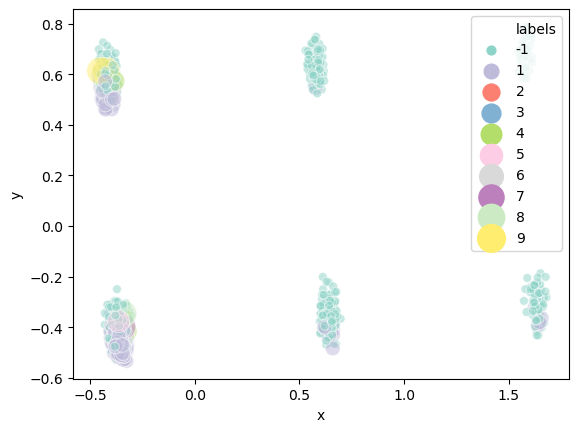

In [34]:
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, size =pca_df.labels, sizes = (40,400),palette="Set3", legend = 'full', alpha = .5)

### We perform PCA for data Visualization in 3D

In [46]:
import plotly.express as px
from sklearn.manifold import TSNE
from matplotlib import animation

In [47]:
def prepare_tsne(n_components, data, cluster_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = cluster_labels

    return df_matrix

In [48]:
def plot_tsne(tsne_data, cluster_labels):
    df_tsne = pd.DataFrame(tsne_data).rename({0: 'x', 1: 'y'}, axis=1)
    df_tsne['z'] = cluster_labels
    sns.scatterplot(x=df_tsne.x, y=df_tsne.y, hue=df_tsne.z, palette="Set2")
    plt.show()

In [49]:
def plot_3d(df, name ='Cluster'):
    fig = px.scatter_3d(df, x='x', y='y', z='z', color=name, opacity=0.5)
    fig.update_traces(marker=dict(size=3))
    fig.show()

In [50]:
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df['x'], df['y'], df['z'], c=df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-25, 35)
    ax.set_xlim(-40, 40)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    ani.save('{}.gif'.format(name), writer='imagemagick')
    plt.show()

In [51]:
tsne_3d_df = prepare_tsne(3, data, new_data['Cluster'])
tsne_3d_df.head()

,x,y,z,labels
0,35.454613,-14.979907,36.244583,-1
1,13.810481,20.629160,-14.448873,-1
2,-21.399296,7.503777,23.245358,-1
3,32.493641,-2.109182,-20.788006,-1
4,6.752229,16.896139,-26.534538,-1


In [52]:
tsne_3d_df['dbscan'] = [str(label) for label in new_data['Cluster']]
plot_3d(tsne_3d_df, name='dbscan')

MovieWriter imagemagick unavailable; using Pillow instead.


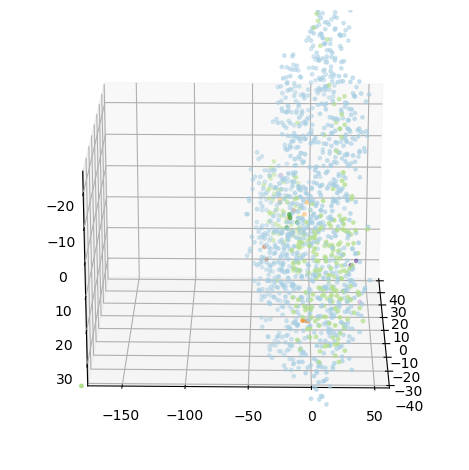

In [53]:
tsne_3d_df.dbscan = tsne_3d_df.dbscan.astype(int)
plot_animation(tsne_3d_df, 'dbscan', 'dbscan_new')

### We perform simple data Visualization

Text(0.5, 1.0, 'Clusters determined by DBSCAN')

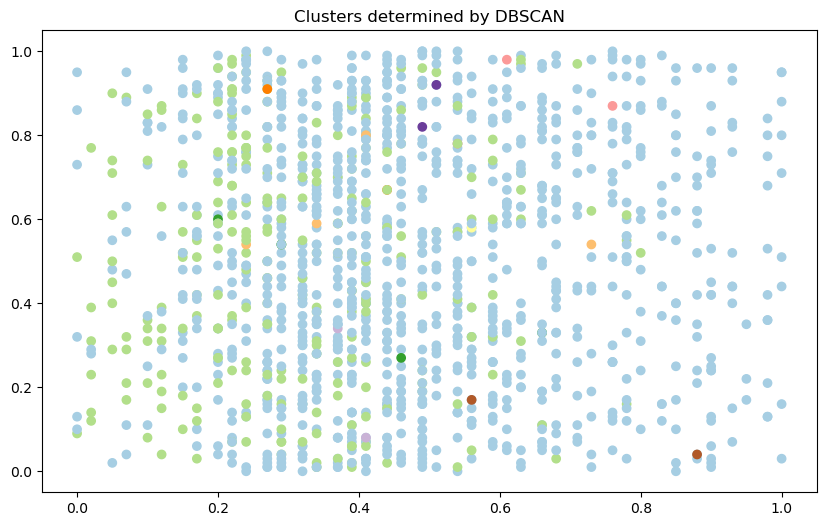

In [54]:
#on visualize avec un scatter plot 2D et deux feature random au lieu de pca ou tsne
plt.figure(figsize=(10,6))
plt.scatter(new_data.iloc[:,0], new_data.iloc[:,2],c=new_data['Cluster'], cmap='Paired')
plt.title("Clusters determined by DBSCAN")

### Visualisation pour souligner les particularités de chaque cluster

In [60]:
from sklearn.preprocessing import MinMaxScaler

In [62]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(data))
df_scaled.columns = data.columns
df_scaled['dbscan'] = new_data['Cluster']
df_scaled.head()

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,dbscan
0,0.56,1.0,0.72,0.00,0.25,0.33,0.0,0.93,0.67,0.25,...,0.00,0.0,0.40,0.00,0.00,0.16,0.24,0.00,0.38,-1
1,0.76,0.5,0.13,0.26,0.00,0.67,1.0,0.45,0.33,0.25,...,1.00,0.5,0.50,0.50,0.67,0.27,0.41,0.07,0.54,-1
2,0.46,1.0,0.91,0.04,0.25,1.00,1.0,0.90,0.33,0.00,...,0.33,0.0,0.35,0.50,0.67,0.00,0.00,0.00,0.00,-1
3,0.37,0.5,0.92,0.07,0.75,1.00,0.0,0.38,0.67,0.00,...,0.67,0.0,0.40,0.50,0.67,0.22,0.41,0.21,0.00,-1
4,0.34,0.5,0.65,0.04,0.25,1.00,1.0,0.71,0.67,0.00,...,0.67,0.0,0.40,0.33,0.33,0.19,0.41,0.21,0.46,-1


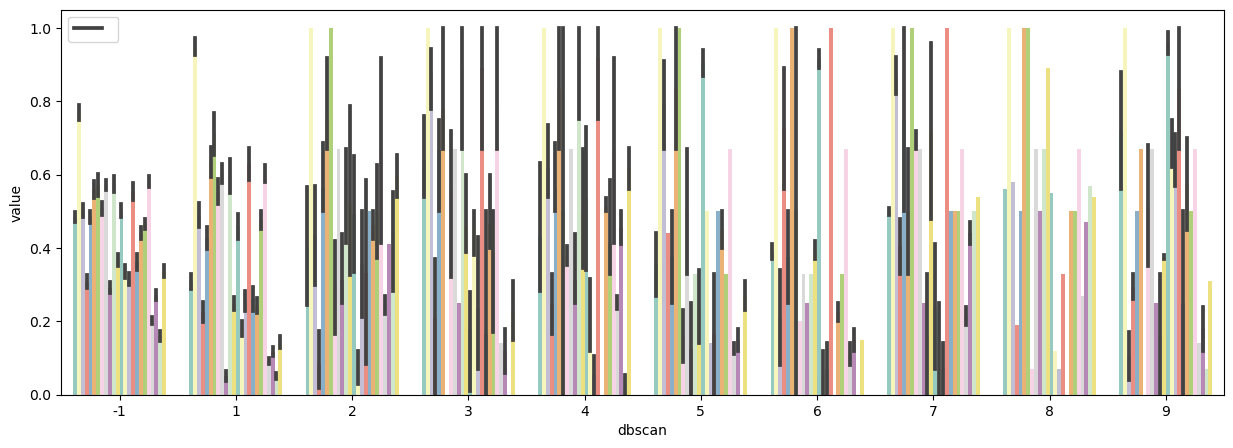

In [63]:
tidy = df_scaled.melt(id_vars='dbscan')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='dbscan', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend([''])
# plt.savefig("mess.jpg", dpi=300)
plt.savefig("dbscan_mess.jpg", dpi=300)
#Nous avons beaucoup de features donc c'est pas pratique, on va faire donc de la feature selection

In [67]:
'''Le technique utilisée pour la feature selection : 
1- Regrouper les points de données par cluster et prendre la moyenne.
2- Calcule de l'écart type entre ces valeurs pour chaque feature.
Concluion : Les features  dont l'écart-type est élevé 
indiquent qu'il existe de grandes différences entre les cluster et que le feature est important. 
'''
df_mean = df_scaled.loc[df_scaled.dbscan!=-1, :].groupby('dbscan').mean().reset_index()
df_mean.head()
#on aura une moyenne pour chaque cluster

,dbscan,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,0.309137,0.94902,0.490745,0.22451,0.427451,0.635961,0.709804,0.553137,0.604235,...,0.254980,0.629333,0.260784,0.242353,0.476784,0.604157,0.09149,0.117686,0.050667,0.142314
1,2,0.402500,1.00000,0.435000,0.08250,0.562500,0.752500,1.000000,0.302500,0.670000,...,0.357500,0.332500,0.500000,0.462500,0.500000,0.667500,0.24500,0.410000,0.445000,0.597500
2,3,0.636667,1.00000,0.876667,0.21000,0.666667,0.780000,0.000000,0.560000,0.670000,...,0.236667,0.890000,0.166667,0.466667,0.390000,0.780000,0.14000,0.120000,0.000000,0.230000
3,4,0.430000,1.00000,0.617500,0.24750,0.562500,0.835000,0.500000,0.372500,0.670000,...,0.052500,0.917500,0.000000,0.512500,0.415000,0.667500,0.25750,0.455000,0.017500,0.617500
4,5,0.355000,1.00000,0.790000,0.44000,0.375000,0.835000,1.000000,0.160000,0.500000,...,0.140000,0.165000,0.500000,0.450000,0.330000,0.670000,0.12500,0.150000,0.000000,0.270000


In [70]:
#on a deja fait le scaling df_scaled
#on a deja calculer la moy par cluster df_mean
#mtn on calcule std pour chaque feature et on trie from highest to lowest variance
results = pd.DataFrame(columns=['Variable', 'Std'])
for column in df_mean.columns[1:]: #on ne prend pas la colonne dbscan
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('Std', ascending=False).head(5).Variable.values) + ['dbscan']

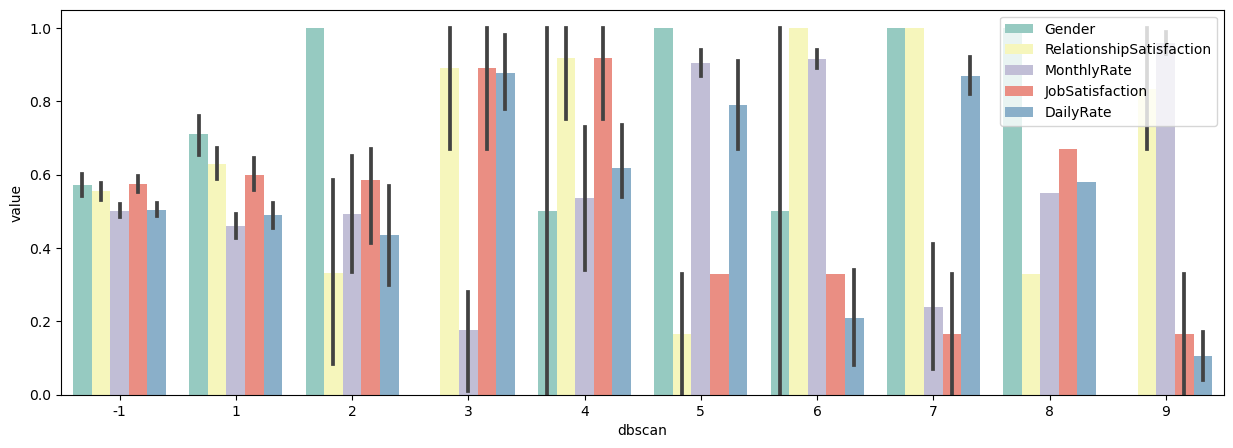

In [71]:
# Plot data
tidy = df_scaled[selected_columns].melt(id_vars='dbscan')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='dbscan', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper right')
plt.savefig("dbscan_results.jpg", dpi=300)

### Diagnostic de nos clusters

In [ ]:
cluster_colors = ['#b4d2b1', '#568f8b', '#1d4a60', '#cd7e59', '#ddb247', '#d15252', '#b4d200','#6f8f8b','#cd7e00','dd525f']


IndexError: index 0 is out of bounds for axis 0 with size 0

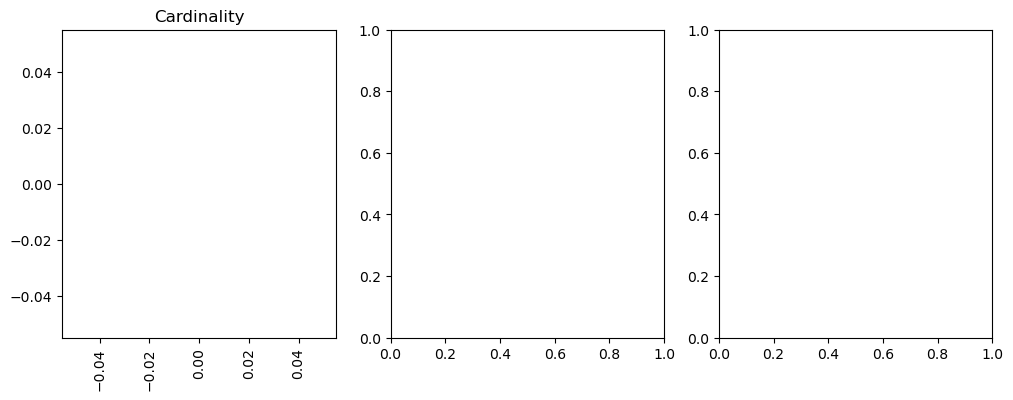

In [80]:
from ds_utils.unsupervised import plot_cluster_cardinality, plot_cluster_magnitude, plot_magnitude_vs_cardinality
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))

plot_cluster_cardinality(new_data['Cluster'], ax=ax1, title="Cardinality", color=cluster_colors)

fig.autofmt_xdate(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
plot_cluster_magnitude(results['Std'],
                       new_data['Cluster'],
                       km_fit.cluster_centers_,
                       euclidean,
                       ax=ax2,
                       title="Magnitude",
                       color=new_data['Cluster']*255
                      )
plot_magnitude_vs_cardinality(results['Std'],
                              new_data['Cluster'],
                              km_fit.cluster_centers_,
                              euclidean,
                              color=new_data['Cluster']*255,
                              ax=ax3, 
                              title="Magnitude vs. Cardinality")

## Application d'algorithmes de clustering basé hiérarchie

In [55]:
# La méthode Lien maximum est utilisée pour retouner a valeur maximale de toutes les
# distances par paires entre les éléments du cluster C1 et les éléments du cluster C2.
# 𝑑𝑖𝑠𝑡(𝐶1, 𝐶2) = 𝑀𝑎𝑥 ( 𝑑𝑖𝑠𝑡(𝑒1, 𝑒2) , 𝑒1 ∈ 𝐶1 𝑒𝑡 𝑒2 ∈ 𝐶2 ).
def complete_linkage(c1, c2):
    distances = np.zeros(len(c1) * len(c2))
    l = 0
    for i in range(len(c1)):
        for j in range(len(c2)):
            distances[l] = np.sum(np.abs(c1[i] - c2[j]))
            l += 1

    return np.amax(distances) # On retourne la valeur maximale de toutes les distances par paires entre les éléments du cluster C1 et les éléments du cluster C2

# La méthode Liaison minimale utilisée pour retouner a valeur minimale de toutes les
# distances par paires entre les éléments du cluster C1 et les éléments du cluster C2.
# 𝑑𝑖𝑠𝑡(𝐶1, 𝐶2) = 𝑀𝑖𝑛 ( 𝑑𝑖𝑠𝑡(𝑒1, 𝑒2) , 𝑒1 ∈ 𝐶1 𝑒𝑡 𝑒2 ∈ 𝐶2 ).
def single_linkage(c1, c2):
    distances = np.zeros(len(c1) * len(c2))
    l = 0
    for i in range(len(c1)):
        for j in range(len(c2)):
            distances[l] = np.sum(np.abs(c1[i] - c2[j]))
            l += 1

    return np.amin(distances) # On retourne la valeur minimale de toutes les distances par paires entre les éléments du cluster C1 et les éléments du cluster C2

# La méthode Liaison moyenne utilisée pour retouner a valeur moyenne de toutes les
# distances par paires entre les éléments du cluster C1 et les éléments du cluster C2.
# 𝑑𝑖𝑠𝑡(𝐶1, 𝐶2) = Σ(𝑒1 ∈ 𝐶1) Σ(𝑒2 ∈ 𝐶2 ) d𝑖𝑠𝑡(𝑒1, 𝑒2) / (𝑛1 * 𝑛2) où 𝑛1 et 𝑛2 sont les tailles des clusters C1 et C2.
def mean_linkage(c1, c2):
    distances = np.zeros(len(c1) * len(c2))
    l = 0
    for i in range(len(c1)):
        for j in range(len(c2)):
            distances[l] = np.sum(np.abs(c1[i] - c2[j]))
            l += 1

    return np.mean(distances) # On retourne la valeur moyenne de toutes les distances par paires entre les éléments du cluster C1 et les éléments du cluster C2

# La méthode Liaison centroid utilisée pour retouner la distance entre les centroides des deux clusters.
def centroid_linkage(c1, c2):
    centroid_c1 = np.mean(c1, axis=0)
    centroid_c2 = np.mean(c2, axis=0)
    return np.sum(np.abs(centroid_c1 - centroid_c2)) # On retourne la distance entre les centroides des deux clusters


def agglomeration_select_function(linkage):
    if linkage == 'complete':
        return complete_linkage
    elif linkage == 'single':
        return single_linkage
    elif linkage == 'average':
        return mean_linkage
    elif linkage == 'centroid':
        return centroid_linkage

# On utiliser cette pour récupérer les index des points du dataset qui sont dans les cluster
def get_instance_index(clusters, data):

    clusters_index = [] # Liste des index des points du dataset qui sont dans les clusters

    for i in range(len(clusters)):

        clusters_temp = [] # Liste temporaire des index des points du dataset qui sont dans le cluster i
        
        for j in range(len(clusters[i])):
            # On récupère l'index du point a partir du dataset
            clusters_temp.append(Counter(np.where(data == clusters[i][j])[0]).most_common(1)[0][0])
        
        clusters_index.append(np.array(list(set(clusters_temp)))) # On ajoute les index du cluster i à la liste des clusters
    
    return np.array(clusters_index)

In [56]:
# Fonction recréant l'algorithme de clustering hiérarchique
def agglomerative_clustering(data, nb_clusters, linkage_method):

    # On initialise les clusters avec les points du dataset (chaque point est un cluster)
    clusters = np.asarray(list(map(lambda el:np.asarray([el]), data.to_numpy())))

    # On défini la fonction de calcul de distance en fonction du type de linkage
    linkage = agglomeration_select_function(linkage_method)

    while len(clusters) != nb_clusters: # Tant qu'on a pas le nombre de clusters voulu
        # On calcule la matrice de distance entre les clusters
        distances = np.zeros((len(clusters), len(clusters)))
        
        for i in range(len(clusters)):
            for j in range(i, len(clusters)):
                if i == j: # On met la distance entre un cluster et lui même à 100000 pour qu'il ne soit pas choisi
                    distances[i][j] = 100000

                else : # On calcule la distance entre le cluster i et le cluster j
                    dist = linkage(clusters[i], clusters[j]) 
                    # On met la distance entre le cluster i et le cluster j et la distance entre le cluster j et le cluster i à la même valeur
                    distances[i][j] = dist
                    distances[j][i] = dist

        temp_dist = distances.copy() # On copie la matrice de distance pour ne pas la modifier
        temps_clusters = clusters.copy() # On copie les clusters pour ne pas les modifier
        new_clusters = [] # Liste des nouveaux clusters

        while len(temp_dist) != 0: # Tant qu'il reste des clusters
            index = np.argmin(temp_dist, axis=1)[0] # On récupère l'index du cluster le plus proche du cluster 0
            new_clusters.append(np.concatenate((temps_clusters[0], temps_clusters[index]))) # On crée le nouveau cluster en concaténant les deux clusters les plus proches

            temps_clusters = np.delete(temps_clusters, 0,  axis= 0) # On supprime le cluster 0
            temp_dist = np.delete(temp_dist , 0,  axis= 0) # On supprime la liste des distances du cluster 0
            temp_dist = np.delete(temp_dist , 0,  axis= 1) # On supprime la distance entre le cluster 0 et les autres clusters

            if index != 0: # Si le cluster le plus proche du cluster 0 n'est pas le cluster 0
                temps_clusters = np.delete(temps_clusters, index - 1,  axis= 0) # On supprime le cluster le plus proche du cluster 0
                temp_dist = np.delete(temp_dist , index - 1,  axis= 0) # On supprime la liste des distances du cluster le plus proche du cluster 0
                temp_dist = np.delete(temp_dist , index - 1,  axis= 1) # On supprime la distance entre le cluster le plus proche du cluster 0 et les autres clusters
        
        clusters = new_clusters # On met à jour les clusters
    
    return get_instance_index(clusters, data) # On retourne les index des points du dataset qui sont dans les clusters

In [57]:
# On teste notre algorithmes
clusters = agglomerative_clustering(data, 2, 'complete')

In [58]:
# On vérifie la taille des clusters obtenus
len(clusters[0]), len(clusters[1])

(894, 423)

In [59]:
# On vérifie les classes des instances des clusters
df_test = pd.read_excel("data.xlsx")
df_test = df_test.drop(['Unnamed: 0'], axis = 1)
Counter(df_test.iloc[clusters[0]]["Attrition"]), Counter(df_test.iloc[clusters[1]]["Attrition"])

(Counter({1: 141, 0: 753}), Counter({0: 354, 1: 69}))